<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/S%26P500_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.4 MB 7.6 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [19]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: ^GSPC
You entered ^GSPC, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
746,2022-01-18,4632.240234,4632.240234,4568.700195,4577.109863,3324960000,0,0
747,2022-01-19,4588.029785,4611.549805,4530.200195,4532.759766,3387370000,0,0
748,2022-01-20,4547.350098,4602.109863,4477.950195,4482.729980,3473060000,0,0
749,2022-01-21,4471.379883,4494.520020,4395.339844,4397.939941,3945810000,0,0
750,2022-01-24,4356.319824,4417.350098,4222.620117,4410.129883,5172540000,0,0
751,2022-01-25,4366.640137,4411.009766,4287.109863,4356.450195,3989420000,0,0
752,2022-01-26,4408.430176,4453.229980,4304.799805,4349.930176,4046270000,0,0
753,2022-01-27,4380.580078,4428.740234,4309.500000,4326.509766,4074330000,0,0
754,2022-01-28,4336.189941,4432.720215,4292.459961,4431.850098,3936030000,0,0
755,2022-01-31,4431.790039,4516.890137,4414.020020,4515.549805,2923395000,0,0


In [20]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.0,756.0
mean,3520.245225,3539.694870,3499.193310,3521.028620,4.089374e+09,0.0,0.0
std,646.852457,647.490010,646.661272,647.038893,1.230464e+09,0.0,0.0
min,2290.709961,2300.729980,2191.860107,2237.399902,1.296540e+09,0.0,0.0
25%,2962.452576,2978.357483,2945.219971,2960.205017,3.273760e+09,0.0,0.0
50%,3327.464966,3341.234985,3316.990112,3327.739990,3.756135e+09,0.0,0.0
75%,4169.335083,4181.390015,4140.492310,4166.735107,4.620298e+09,0.0,0.0
max,4804.509766,4818.620117,4780.040039,4796.560059,9.878040e+09,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [21]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [22]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [23]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [24]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [25]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [26]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [27]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
751,2022-01-25,4356.450195
752,2022-01-26,4349.930176
753,2022-01-27,4326.509766
754,2022-01-28,4431.850098
755,2022-01-31,4515.549805


## Creating Facebook Prophet Model

In [28]:
m=Prophet(yearly_seasonality=True)
m.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##Forecasting

In [29]:
periods = 30
future=m.make_future_dataframe(periods)

In [30]:
forecast=m.predict(future)

In [31]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-01,2703.054003,2618.689318,2818.960941,2703.054003,2703.054003,19.312352,19.312352,19.312352,3.361013,3.361013,3.361013,15.951339,15.951339,15.951339,0.0,0.0,0.0,2722.366355
1,2019-02-04,2716.423918,2652.794128,2850.159686,2716.423918,2716.423918,37.987023,37.987023,37.987023,-0.028273,-0.028273,-0.028273,38.015296,38.015296,38.015296,0.0,0.0,0.0,2754.410940
2,2019-02-05,2720.880556,2669.218236,2865.113849,2720.880556,2720.880556,48.775140,48.775140,48.775140,3.096766,3.096766,3.096766,45.678374,45.678374,45.678374,0.0,0.0,0.0,2769.655696
3,2019-02-06,2725.337194,2686.916026,2875.195774,2725.337194,2725.337194,56.605571,56.605571,56.605571,3.371084,3.371084,3.371084,53.234487,53.234487,53.234487,0.0,0.0,0.0,2781.942765
4,2019-02-07,2729.793832,2690.972282,2890.876828,2729.793832,2729.793832,61.877205,61.877205,61.877205,1.350748,1.350748,1.350748,60.526457,60.526457,60.526457,0.0,0.0,0.0,2791.671038
5,2019-02-08,2734.250471,2711.989551,2899.530983,2734.250471,2734.250471,70.761641,70.761641,70.761641,3.361013,3.361013,3.361013,67.400628,67.400628,67.400628,0.0,0.0,0.0,2805.012111
6,2019-02-11,2747.620385,2735.089803,2926.238047,2747.620385,2747.620385,84.057917,84.057917,84.057917,-0.028273,-0.028273,-0.028273,84.086190,84.086190,84.086190,0.0,0.0,0.0,2831.678302
7,2019-02-12,2752.077024,2753.823282,2934.716467,2752.077024,2752.077024,91.007470,91.007470,91.007470,3.096766,3.096766,3.096766,87.910704,87.910704,87.910704,0.0,0.0,0.0,2843.084494
8,2019-02-13,2756.533662,2743.791362,2944.661710,2756.533662,2756.533662,94.057996,94.057996,94.057996,3.371084,3.371084,3.371084,90.686912,90.686912,90.686912,0.0,0.0,0.0,2850.591657
9,2019-02-14,2760.990300,2758.890025,2953.097993,2760.990300,2760.990300,93.680952,93.680952,93.680952,1.350748,1.350748,1.350748,92.330204,92.330204,92.330204,0.0,0.0,0.0,2854.671252


In [32]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

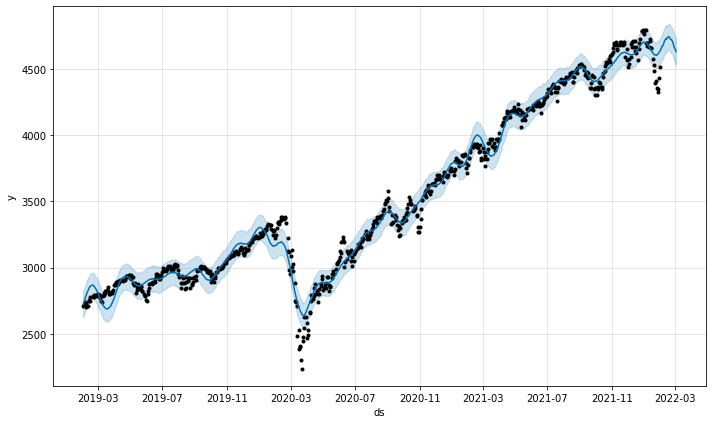

In [33]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

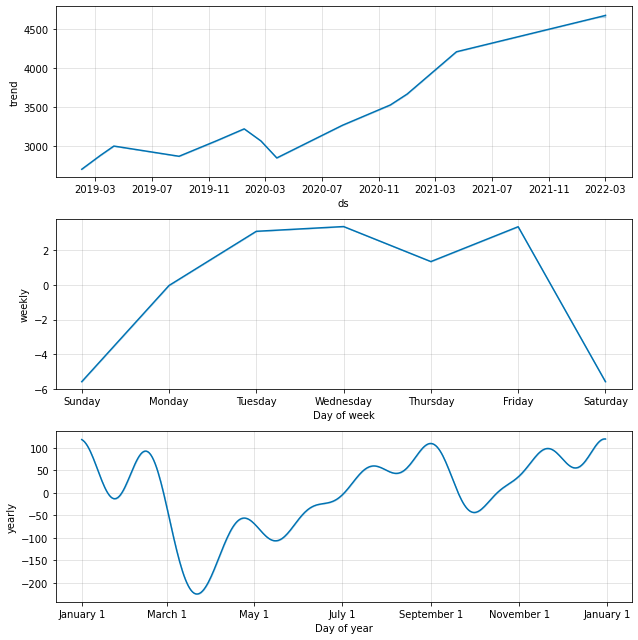

In [34]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [35]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>